### Решающие деревья и случайные леса.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

In [3]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import graphviz
import typing as tp
import scipy.stats as sps
from sklearn.preprocessing import OneHotEncoder

Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

Например, вместо/дополнительно признака $x_j$ рассматривать признак $f(x_j)$, для указанных выше типов функций.

По идее, ничего из выше перечисленного делать не надо, кроме преобразования категориальных признаков, но в нашем случае это делать не обязательно.
Решающее дерево само учитывает зависимости между признаками, поэтому применять монотонные и немонотонные функции смысла нет
Аналогично, не имеет смысла применять линейные и нелинейные функции от нескольких признаков (решающее дерево само найдет наилучшую комбинацию)
Решающее дерево не зависит от масштаба признаков, поэтому делать стандартизацию также необязательно.
Преобразование категориальных признаков нужно делать, если значения категориальных признаков достаточно большое количество, тк тогда решающему дереву придется переберать 2^n (n - кол-во принимаемых значений)"слитков", что плохо скажется на времени, в нашем же случае, категориальные признаки принимают малое количество значений.

Скачаем данные и разделим их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

Cразу удалим ненужные столбцы: 'atemp' - в прошлом задание было объяснение, что это не нужно, 'casual', 'registered - эти столбцы косвенно содержит целевой признак, 'dteday' - дата не влияет на арендуемость, а дни недели, месяц и сезон мы уже учитваем в других столбцах.

In [4]:
data = pd.read_csv("day.csv")
data = data[["season", "mnth", "holiday", "weekday","workingday", "weathersit", "temp",
                   "hum", "windspeed", "cnt", "yr"]]
data

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,yr
0,1,1,0,6,0,2,0.344167,0.805833,0.160446,985,0
1,1,1,0,0,0,2,0.363478,0.696087,0.248539,801,0
2,1,1,0,1,1,1,0.196364,0.437273,0.248309,1349,0
3,1,1,0,2,1,1,0.200000,0.590435,0.160296,1562,0
4,1,1,0,3,1,1,0.226957,0.436957,0.186900,1600,0
...,...,...,...,...,...,...,...,...,...,...,...
726,1,12,0,4,1,2,0.254167,0.652917,0.350133,2114,1
727,1,12,0,5,1,2,0.253333,0.590000,0.155471,3095,1
728,1,12,0,6,0,2,0.253333,0.752917,0.124383,1341,1
729,1,12,0,0,0,1,0.255833,0.483333,0.350754,1796,1


In [5]:
dteach = data.sample(int(0.6*len(data.index)))  # обучающие
temp = data.drop(dteach.index) 
dtest = temp.sample(int(0.5*len(temp.index)))  # тестовые
dval = temp.drop(dtest.index)  # Валидационные

 

Удалим выбросы 

In [6]:
def delkak(df: pd.DataFrame) -> pd.DataFrame:
    a1 = df.windspeed.quantile([0.25,0.75]).iloc[0]
    a2 = df.windspeed.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['windspeed'] < a2 + delt]
    df = df[df['windspeed'] > a1 - delt]
    
    a1 = df.hum.quantile([0.25,0.75]).iloc[0]
    a2 = df.hum.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['hum'] < a2 + delt]
    df = df[df['hum'] > a1 - delt]
    
    a1 = df.temp.quantile([0.25,0.75]).iloc[0]
    a2 = df.temp.quantile([0.25,0.75]).iloc[1]
    delt = (a2 - a1) 
    df = df[df['temp'] < a2 + delt]
    df = df[df['temp'] > a1 - delt]
    
    return df

In [7]:
print(len(dteach))
train = delkak(dteach)
print(len(train))

438
398


In [8]:
print(len(dval))
dval = delkak(dval)
print(len(dval))

147
128


In [9]:
print(len(dtest))
dtest = delkak(dtest)
print(len(dtest))

146
135


Выделем отдельно целевой признак.

In [10]:
X_train = train.drop(columns='cnt')
y_train = train['cnt']

In [11]:
X_valid = dval.drop(columns='cnt')
y_valid = dval['cnt']

In [12]:
X_test = dtest.drop(columns='cnt')
y_test = dtest['cnt']

Обучим решающее дерево глубины 3 и визуализируем его. 

In [13]:
clf = DecisionTreeRegressor(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

В дальнейшем будем анализировать ошибку MAPE. Посчтаем ее для обученного дерева на тестовых данных

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [15]:
predictions = clf.predict(X_test)
mean_absolute_percentage_error(y_test, predictions)

21.048985441631157

In [16]:
def get_graphviz_graph(decision_tree_regressor):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    
    decision_tree_regressor.fit(X_train, y_train)
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=X_train.columns, class_names='Price',  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data) 

Визуализируем

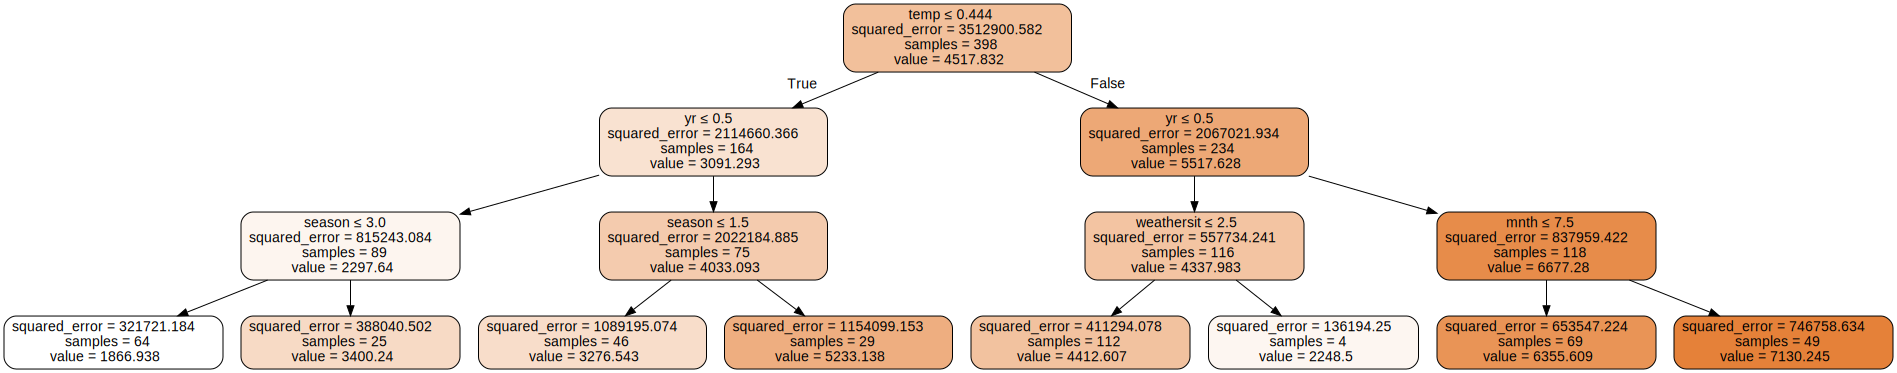

In [20]:
graph = get_graphviz_graph(clf)
graph.save("д1.html")
graph

Подберем оптимальное значение максимальной глубины дерева. Для этого обучим решающие деревья с выставленным значением соответствующего гиперпараметра и посчитаем ошибку предсказаний каждого из них на валидационной выборке. Построим соответствующий график.

In [21]:
ans = [i for i in range(1, 50)]
mape = []

for i in range(1, 50):
    clf = DecisionTreeRegressor(max_depth=i)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    mape.append(mean_absolute_percentage_error(y_valid, predictions))

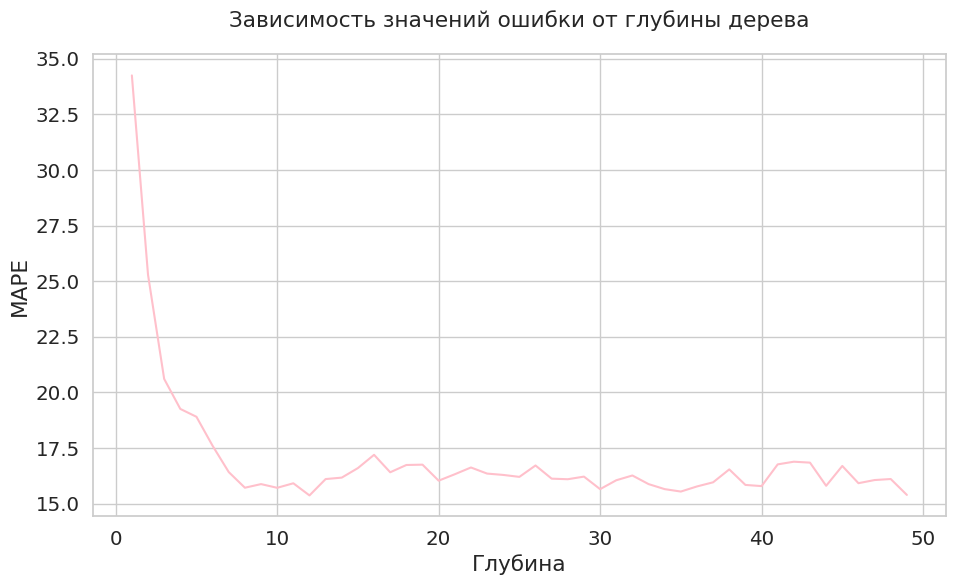

In [22]:
plt.figure(figsize=(11, 6))

plt.plot(ans, mape, color='pink')

plt.title("Зависимость значений ошибки от глубины дерева", pad=20)
plt.xlabel("Глубина")
plt.ylabel("MAPE")
plt.show()

Минимальная ошибка при глубине 12. Зафиксируем этот параметр.

Аналогичным образом подберем минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [25]:
ans = [i for i in range(2, 110)]
mape = []

for i in range(2, 110):
    clf = DecisionTreeRegressor(max_depth=12, min_samples_split=i)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    mape.append(mean_absolute_percentage_error(y_valid, predictions))

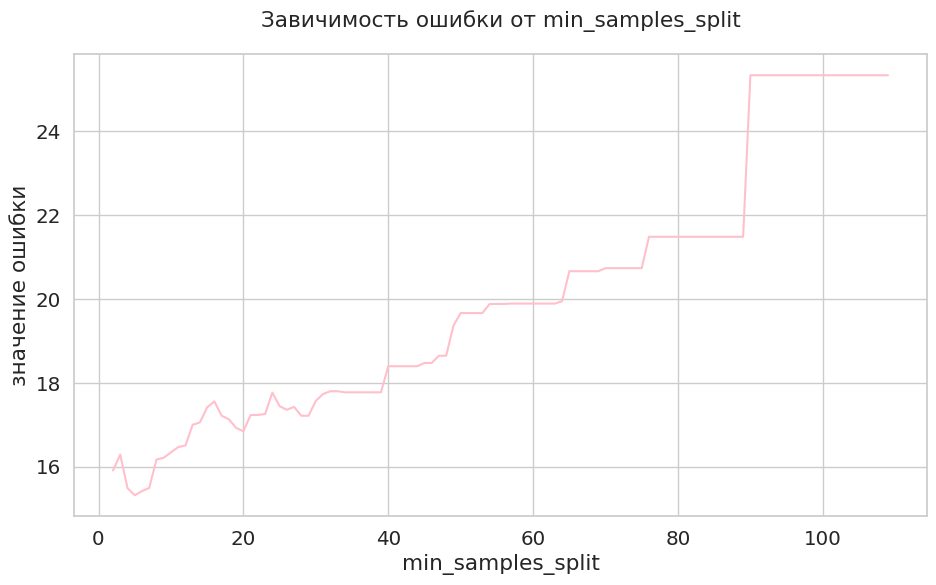

In [26]:
plt.figure(figsize=(11, 6))

plt.plot(ans, mape, color='pink')

plt.title("Завичимость ошибки от min_samples_split", pad=20)
plt.xlabel("min_samples_split")
plt.ylabel("значение ошибки")
plt.show()

Минимальная ошибка соответствует min_samples_split=4. Зафиксируем этот параметр.

Визуализируем дерево при оптимальных гиперпараметрах и посчитаем его ошибку на тестовой части выборки.

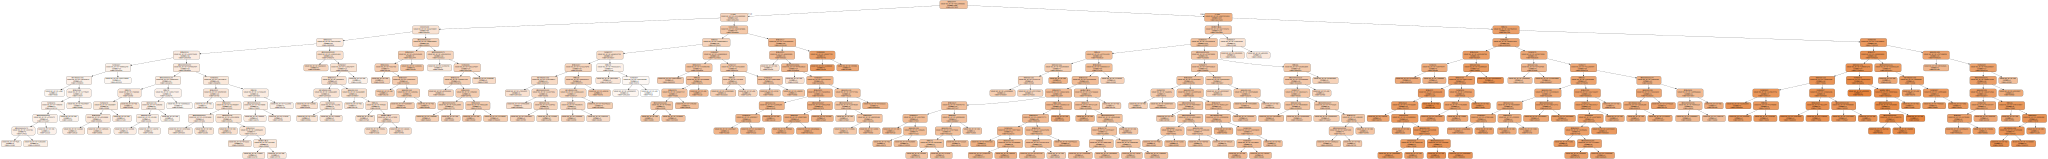

In [35]:
clf = DecisionTreeRegressor(max_depth=12, min_samples_split=4)
clf.fit(X_train, y_train)
graph = get_graphviz_graph(clf)
graph.save("Дерево2.html")
graph

Посмотрим на ошибку, которая возникает при оптимальном подборе параметров.

In [36]:
predictions = clf.predict(X_test)

mean_absolute_percentage_error(y_test, predictions)

19.33424541479885

Заметим, что теперь ошибка чуть ниже, чем при не выставленных параметрах.

Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируем их с помощью `seaborn.barplot`.

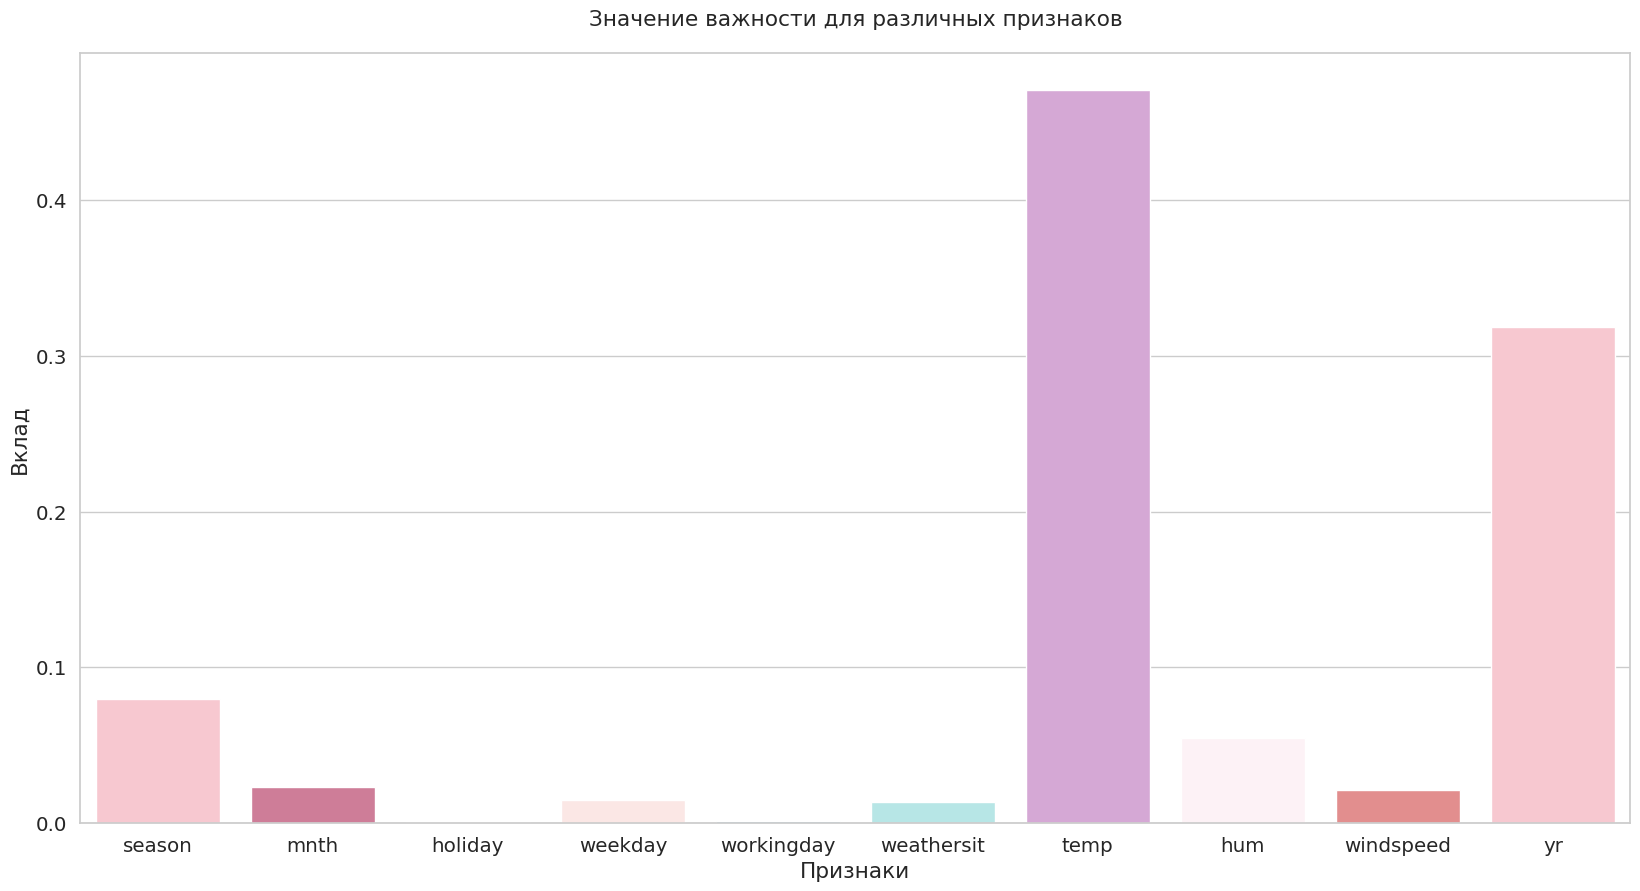

In [37]:
cl=['pink', 'palevioletred', 'powderblue', 'mistyrose', 'skyblue', 'paleturquoise', 'plum', 'lavenderblush', 'lightcoral']
plt.figure(figsize=(20, 10))
sns.barplot(pd.DataFrame({'name': X_train.columns, 'ans': clf.feature_importances_},
                         columns=['name', 'ans']), x='name', y='ans', palette=cl)

plt.title("Значение важности для различных признаков", pad=20)
plt.xlabel("Признаки")
plt.ylabel("Вклад")
plt.show()

Видно, что самыми влиятельными признаками оказались: температура, год и сезон. Самый маленький вклад внесли прадники, рабочие дни, дни недели, скорость ветра и погодная оценка.



**Вывод:**

В ходе исследования были подобраны оптимальные параметры для модели решающего дерева: при хорошем подборе параметров МАРЕ получается около 19%, что на 2% лучше, чем без подбора парметров. В целом, модель достаточно хорошо справилась с предсказанием тестовых параметров (в сравнении с моделями из прошлого задания). Самыми влиятельными признаками в полученной модели оказались: температура, год и сезон. Самый маленький вклад внесли прадники, рабочие дни, дни недели, скорость ветра и погодная оценка.

Обучим случайный лес на 500 деревьев.

In [54]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

Построим график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.


In [55]:
ans = [i for i in range(3, 501)]
mape = []

for i in range(3, 501):
    trees = model.estimators_[0:i]
    
    predictions = np.zeros((X_valid.shape[0], i))
    for i, tree in enumerate(trees):
        predictions[:, i] = tree.predict(X_valid.values)
    
    rf_predictions = np.mean(predictions, axis=1)
    mape.append(mean_absolute_percentage_error(y_valid, rf_predictions))

Вначале построим для **валидационных** данных

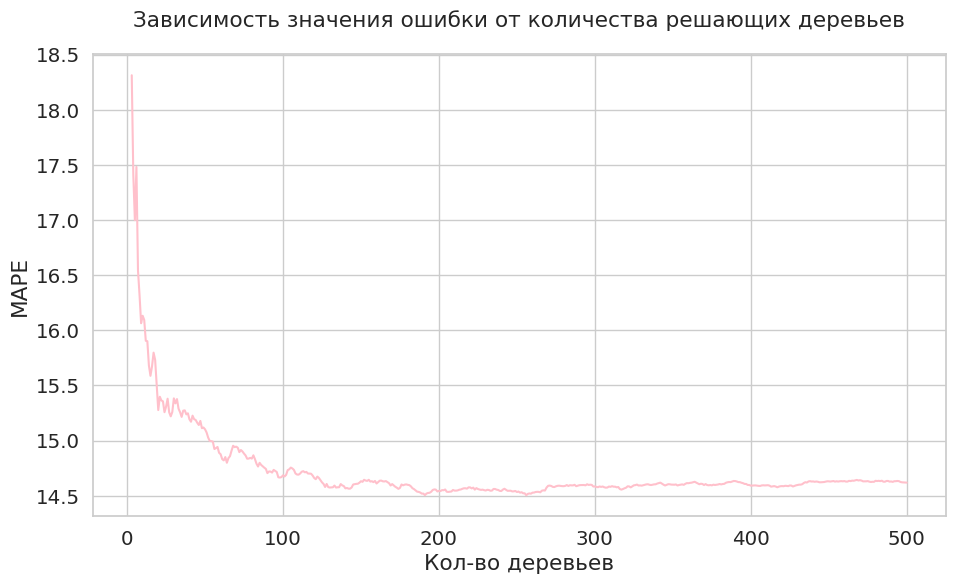

In [56]:
plt.figure(figsize=(11, 6))

plt.plot(ans, mape, color='pink')

plt.title("Зависимость значения ошибки от количества решающих деревьев", pad=20)
plt.xlabel("Кол-во деревьев")
plt.ylabel("MAPE")
plt.show()

Из графика видно, что при количестве деревьев >150 значение ошибки выравнивается. В нашем случае строить модель с меньшим количеством деревьев не целесообразно.

Построим для **тренировочных** данных

In [57]:
ans1 = [i for i in range(3, 501)]
mape1 = []

for i in range(3, 501):
    trees = model.estimators_[0:i]
    
    predictions = np.zeros((X_train.shape[0], i))
    for i, tree in enumerate(trees):
        predictions[:, i] = tree.predict(X_train.values)
    
    rf_predictions = np.mean(predictions, axis=1)
    mape1.append(mean_absolute_percentage_error(y_train, rf_predictions))

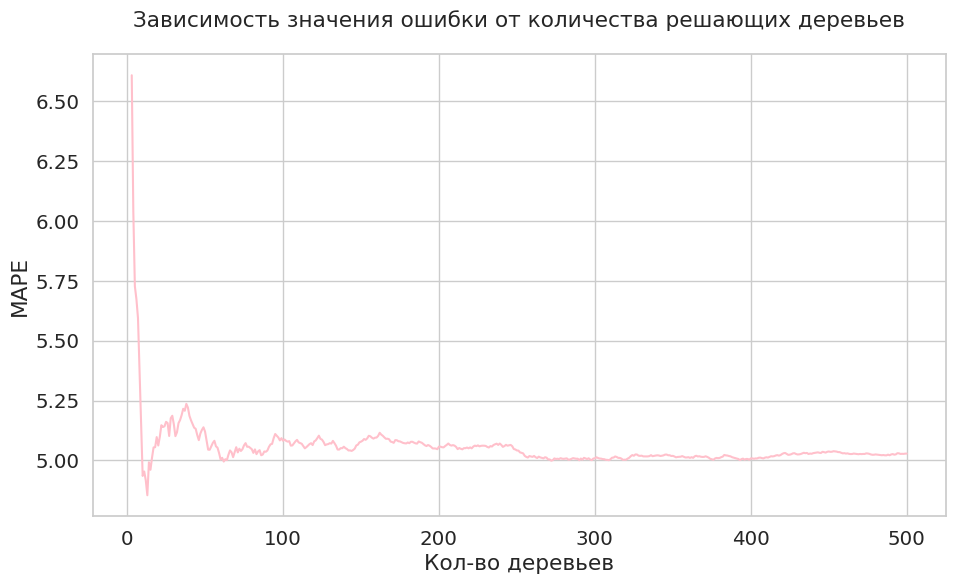

In [58]:
plt.figure(figsize=(11, 6))

plt.plot(ans1, mape1, color='pink')

plt.title("Зависимость значения ошибки от количества решающих деревьев", pad=20)
plt.xlabel("Кол-во деревьев")
plt.ylabel("MAPE")
plt.show()

Построим зависимость для двух выборок на одном графике, чтобы стало нагляднее.

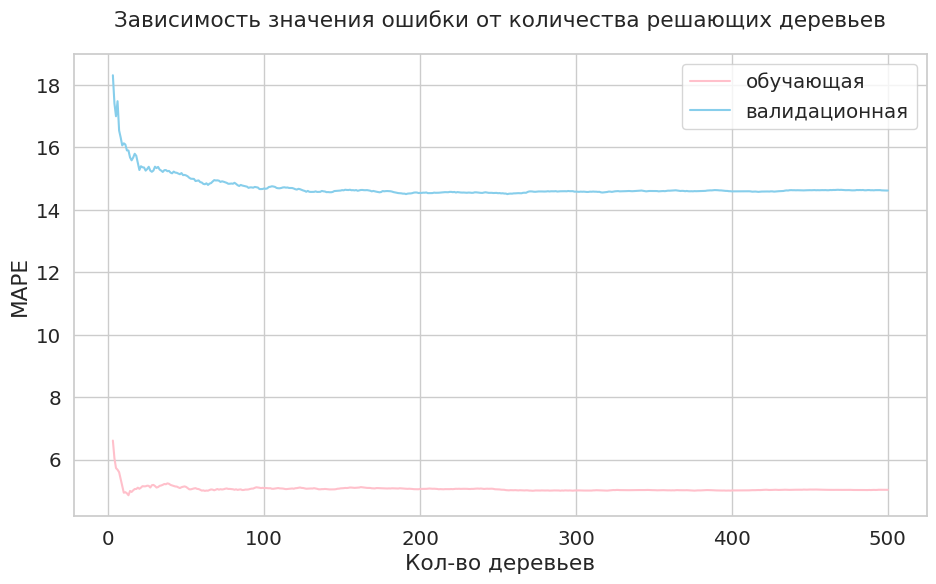

In [61]:
plt.figure(figsize=(11, 6))

plt.plot(ans1, mape1, color='pink')
plt.plot(ans, mape, color='skyblue')

plt.title("Зависимость значения ошибки от количества решающих деревьев", pad=20)
plt.xlabel("Кол-во деревьев")
plt.ylabel("MAPE")
plt.legend(["обучающая", "валидационная"])
plt.show()

Из графика видно, что средняя разница между ошибками на валидационной и тренировочной выборке около 12%

Для леса с максимальным количеством деревьев визуализируем 
важность признаков

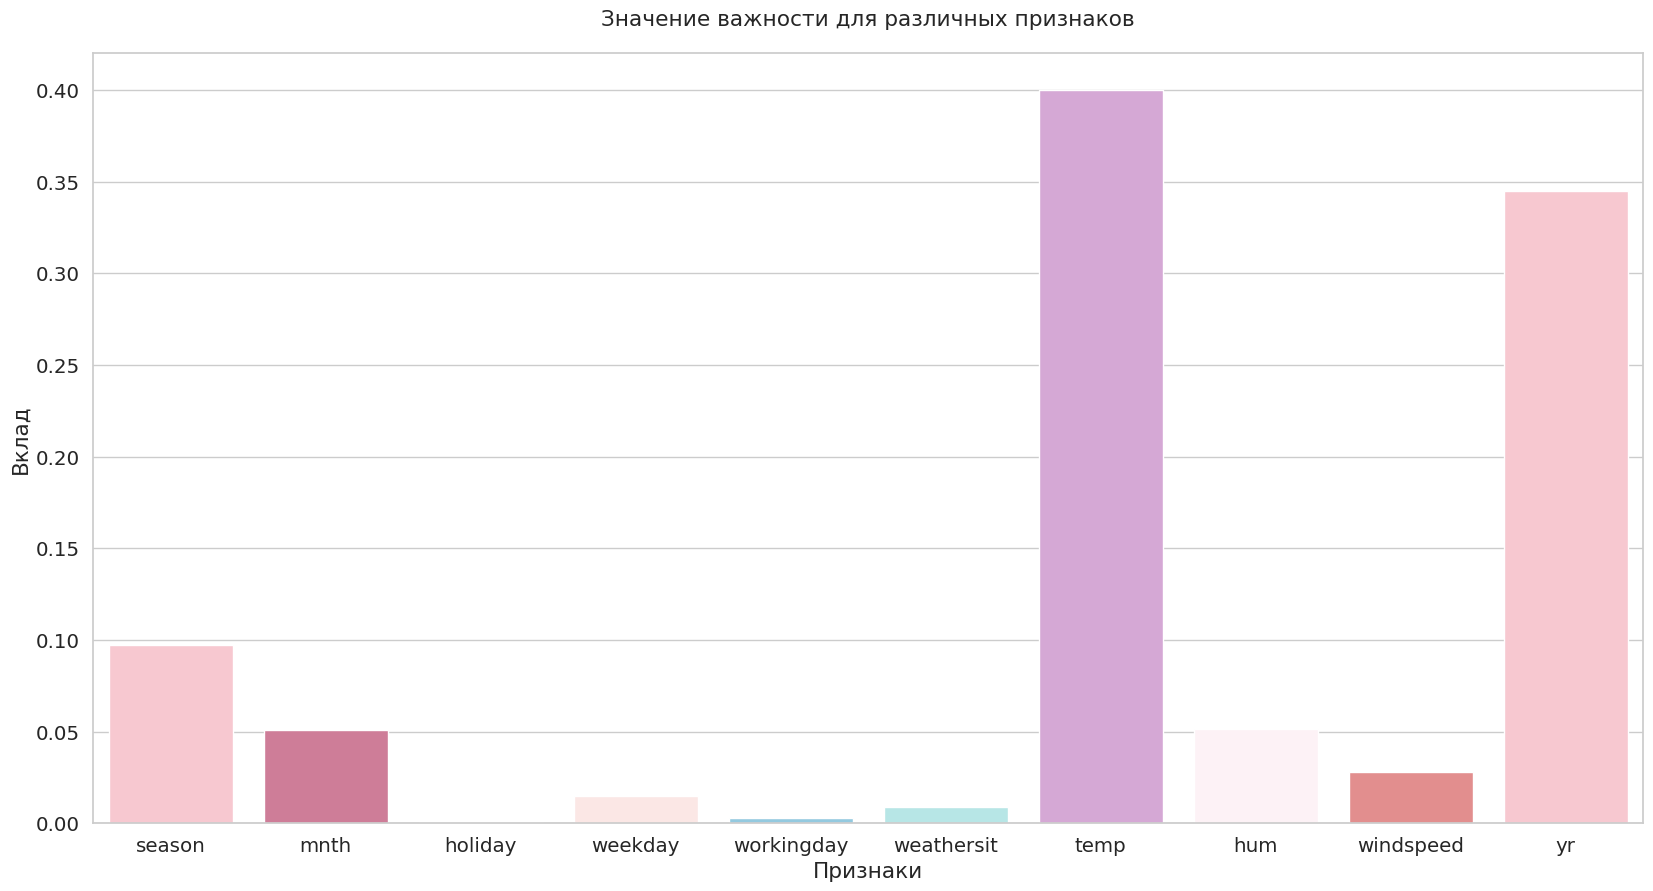

In [47]:
cl=['pink', 'palevioletred', 'powderblue', 'mistyrose', 'skyblue', 'paleturquoise', 'plum', 'lavenderblush', 'lightcoral']
plt.figure(figsize=(20, 10))
sns.barplot(pd.DataFrame({'name': X_train.columns, 'ans': model.feature_importances_},
                         columns=['name', 'ans']), x='name', y='ans', palette=cl)

plt.title("Значение важности для различных признаков", pad=20)
plt.xlabel("Признаки")
plt.ylabel("Вклад")
plt.show()

Видно, что самыми влиятельными признаками оказались: температура, год и сезон. Самый маленький вклад внесли прадники, рабочие дни, дни недели и погодная оценка.

In [48]:
predictions = model.predict(X_test)
mean_absolute_percentage_error(y_test, predictions)

15.380466438452004

**Вывод**
Ошибка MAPE при работе с лесом решающих деревьев получилась равной 15% - это лучше, чем в предыдущем опыте (ошибка на 4% ниже). Подбор количества деревьев в лесе показал, что после 150 деревьев значение ошибки выравнивается. В данном случае имеет смысл делать лес >=150. Также графики позволили увидеть, что разница между ошибкой на валидационной и тренировочной выборке ~12%. В целом модель показала дочтаточно хороший результат, если выбрать правильное значение размера леса. Аналогично предыдущему опыту - самый большой вклад вносят признаки: температура, год и сезон. Самый маленький вклад - праздники, рабочие дни, день недели и оценка погоды.